# SaxaVord EO Challenge

Welcome to your challenge: Focussing on an Area of Interest (AOI) over the Faroe Islands, you can look at either: 

* Quantify the extent of algae bloom changes, and their impact on nearby Salmon Fishing Farms
* Quantify the extent of recent coastal erosion 

## Check Environment Active

In [ ]:
# Desktop UI:
# It should also show this on the top RHS of your screen, below the LogOut button

In [1]:
# Conda
#  -- Activate environment will show a '*' next to it
!conda env list

# conda environments:
#
base                     /Users/taracunningham/miniconda3
acolite                  /Users/taracunningham/miniconda3/envs/acolite
convml-tt                /Users/taracunningham/miniconda3/envs/convml-tt
cv                       /Users/taracunningham/miniconda3/envs/cv
detectron2               /Users/taracunningham/miniconda3/envs/detectron2
kenya                 *  /Users/taracunningham/miniconda3/envs/kenya
munromap                 /Users/taracunningham/miniconda3/envs/munromap
oosa                     /Users/taracunningham/miniconda3/envs/oosa
pyenv                    /Users/taracunningham/miniconda3/envs/pyenv
sense-abm                /Users/taracunningham/miniconda3/envs/sense-abm
sense2020                /Users/taracunningham/miniconda3/envs/sense2020
sensecdt_env             /Users/taracunningham/miniconda3/envs/sensecdt_env
snap-py36                /Users/taracunningham/miniconda3/envs/snap-py36
tigis                    /Users/taracunningham/miniconda3/env

In [ ]:
# Pip
# TODO: Add this for pip !pip XYZ

## Import Packages

In [2]:
# Packages
import os
import glob

import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile


In [3]:
# Visualisation Params
%matplotlib inline    # plots images in the Jupyter notebook cells
%matplotlib qt5       # opens a seperate browser window to view images

UsageError: unrecognized arguments: # plots images in the Jupyter notebook cells


# Sentinel 2

### The Data Folder Structure
Satellite imagery products are folders which contain satellite imagery data in a standardised way, including standard naming conventions for folders etc. Please see the SaxaVord PDF for an explanation of the Sentinel 2 naming convention. 

A single image  product of a region at DateTime YYYYMMDD-HHMMSS is packaged in a folder with a hierarchical file structure. In our case this is:

    |- S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212 *folder for a single day-time image product*
        |-S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212.SAFE
            |-GRANULE
                |-L2A_T30VUQ_A036242_20220531T120405
                    |-IMG_DATA
                        |- R10m  *resolution folders*
                            |-T30VUQ_20220531T120411_B02_10m.jp2 *individual band file*
                            |-T30VUQ_20220531T120411_B03_10m.jp2
                            |-...
                            |-T30VUQ_20220531T120411_TCI_10m.jp2 *TCI = true color image, multi-band file *

                        |- R20m
                            |-T30VUQ_20220531T120411_B02_20m.jp2
                            |-T30VUQ_20220531T120411_B03_20m.jp2
                            |-...
                        |- R60m
                            |-T30VUQ_20220531T120411_B02_60m.jp2
                            |-T30VUQ_20220531T120411_B03_60m.jp2
                            |-...


### Image Bands
* True Colour Images (RGB) are comprised of 3 bands, Red, Green and Blue - the visible light section of the Electromagnetic Spectrum. 

* Satellite sensors cover a far broader section of this spectrum, and therefore capture a larger number of bands. 

* Different phenomena on earth and within the atmosphere react differently to wavelengths across the spectrum (e.g. different bands), allowing us to make inferences about what is occuring below.

* Certain bands are therefore useful for different environmental analyses.

* Below is a table of the bands that Sentinel 2 collects, their resolutions and descriptions (from https://gisgeography.com/sentinel-2-bands-combinations/).

* More information about how the data is collected and the different bands can be found in the [Sentinel 2 user guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi) on the European Space Agency website.

|Band | Resolution | Central wavelength | Description |
|-----|------------|--------------------|-------------|
|B1	  |60 m	       |443 nm	            |Ultra Blue (Coastal and Aerosol)|
|B2	  |10 m	       |490 nm	            |Blue|
|B3	  |10 m	       |560 nm	            |Green|
|B4	  |10 m	       |665 nm	            |Red|
|B5	  |20 m	       |705 nm	            |Visible and Near Infrared (VNIR)|
|B6	  |20 m	       |740 nm	            |Visible and Near Infrared (VNIR)|
|B7	  |20 m	       |783 nm	            |Visible and Near Infrared (VNIR)|
|B8	  |10 m	       |842 nm	            |Visible and Near Infrared (VNIR)|
|B8a  |20 m	       |865 nm	            |Visible and Near Infrared (VNIR)|
|B9	  |60 m	       |940 nm	            |Short Wave Infrared (SWIR)|
|B10  |60 m	       |1375 nm             |Short Wave Infrared (SWIR)|
|B11  |20 m	       |1610 nm             |Short Wave Infrared (SWIR)|
|B12  |20 m	       |2190 nm             |Short Wave Infrared (SWIR)|


### Working with This Data
For our data we have:
* Images for a set of dates throughout time
* Each image has multiple bands in multiple resolutions
* The filepath for each band is going to be very verbose and difficult to track due to the hierarchical structure

To make all these paths easier to work with, we shall give each Image into it's own dictionary and store all filepaths there. This will enable easy referencing. The code below creates these dictionaries for you.

```
img_band_dict = {
                'img_folder': 'S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212',

                 'img_date': '20220531',
                 'img_time': '183212',
                 
                 'R10m':{'B02': 'T30VUQ_20220531T120411_B02_10m.jp2',
                         'B03': 'T30VUQ_20220531T120411_B03_10m.jp2',
                         ...
                         'TCI': 'T30VUQ_20220531T120411_TCI_10m.jp2'
                        },
                        
                  'R20m':{'B02': 'T30VUQ_20220531T120411_B02_20m.jp2',
                          'B03': 'T30VUQ_20220531T120411_B03_20m.jp2',
                           ...
                          },
                          
                  'R60m':{'B02': 'T30VUQ_20220531T120411_B02_60m.jp2',
                          'B03': 'T30VUQ_20220531T120411_B03_60m.jp2',
                           ...
                          }
                 }
                 
```
                 

**For Example:** To create a True Colour Image (RGB) at 10m resolution, we use Red (B04), Green (B03), Blue (B02). The individual bands can then be accessed:

```
## 10m resolution:
r_10m_filepath = img_band_dict['R10m']['B04']
r_10m_band_img = get_band(r_10m_filepath)

g_10m_filepath = img_band_dict['R10m']['B03']
g_10m_band_img = get_band(g_10m_filepath)

b_10m_filepath = img_band_dict['R10m']['B02']
b_10m_band_img = get_band(b_10m_filepath)
```

## Zipped Image Folders: Rename & Extract All Data

In [13]:
# Function to extract source folder.zip to targer folder
def extract_from_zip(source, target):
    with ZipFile(source, 'r') as zip_ref:
        zip_ref.extractall(target)     

In [14]:
# Path from notebook to folder containing zipped folder for each day's data
s2_imgs_folder = 'Faroe Islands Satellite Data'

# Select your joiner 
# MAC 
jn = '/'

# WINDOWS
jn = '\\'


# Windows: Zip Folder names may be too long upon extraction, shorten names by removing characters from name from '_N0400' onwards
for file_name in os.listdir(s2_imgs_folder):
    file = ''
    file = s2_imgs_folder + jn + file_name #TODO: switch '\\' to '/' for Mac
    
    # Only perform operation of zipped folders
    if file.endswith('.zip'):
        t = '_N0400'
        ind = file.find(t)
        
        # Renaming required
        if ind>=0:    
            file_new = file[:ind] + '.zip'
            os.rename(file, file_new)

        # No renaming required
        else:
            file_new = file
            
        # Extract all files from .zip
        file_new_unzip = file_new[:-4]
        extract_from_zip(file_new, file_new_unzip)
        
             
# Check name shortened, and folders unzipped correctly        
os.listdir(s2_imgs_folder)

['S2A_MSIL2A_20220531T120411',
 'S2A_MSIL2A_20220531T120411.zip',
 'S2A_MSIL2A_20220607T115411',
 'S2A_MSIL2A_20220607T115411.zip',
 'S2B_MSIL2A_20220327T120359',
 'S2B_MSIL2A_20220327T120359.zip',
 'S2B_MSIL2A_20220419T121349',
 'S2B_MSIL2A_20220419T121349.zip',
 'S2B_MSIL2A_20220705T120359',
 'S2B_MSIL2A_20220705T120359.zip',
 'S2B_MSIL2A_20220831T115359',
 'S2B_MSIL2A_20220831T115359.zip']

## Create Dictionaries of Band File Paths

In [8]:
# Using new directory structure and .SAFE extension as the selector

# set directory with Sentinel 2 data
sen2dir = './starter_data/sentinel2/'

# get list of image directories
lst = os.listdir(sen2dir)
img_dirs_lst = [x for x in lst if x.endswith('.SAFE')]

print(img_dirs_lst)

['S2B_MSIL2A_20220705T120359_N0400_R066_T30VUQ_20220705T160213.SAFE', 'S2B_MSIL2A_20220327T120359_N0400_R066_T29VPK_20220327T163425.SAFE', 'S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212.SAFE', 'S2B_MSIL2A_20220831T115359_N0400_R023_T29VPK_20220831T141847.SAFE', 'S2A_MSIL2A_20220607T115411_N0400_R023_T29VPK_20220607T182818.SAFE', 'S2B_MSIL2A_20220419T121349_N0400_R109_T29VPK_20220419T150207.SAFE']


In [9]:
# For each unzipped folder (a single day product), go in & extract all '.jp2' filepaths for the bands into a dictionary
# Store all dictionaries in a list (all_img_dicts)

all_img_dicts = []
jn = '/'

#for img_folder in unzipped_img_folders:
for img_folder in img_dirs_lst:

    ## List all band filenames
    # img_folder = 'S2B_MSIL2A_20220419T121349'
    date = img_folder[11:19]
    time = img_folder[20:26]
    f = sen2dir + jn + img_folder + jn
    #f = s2_imgs_folder + jn + img_folder + jn

    # Sub-folders containing band data
    res_set = ['R10m', 'R20m', 'R60m']

    # Create a dictionary of the band names
    bands = ['B01','B02','B03','B04','B05','B06', 'B07','B08', 'B8A', 'B09' ,'B10','B11','B12', 'AOT','TCI','WVP', 'SCL']

    all_band_files = [ x for x in glob.glob(f + '**' + jn + '*', recursive=True) if any(res in x for res in res_set) and x.endswith('jp2')]


    img_band_dict = {'img_folder':img_folder,
                     'img_date':date,
                     'img_time':time}

    # Create a key for each resolution
    for res in res_set:
        img_band_dict[res] = {}

    # Assign all band filepaths to dict
    for band_file in all_band_files:

        # For each resolution, get all band filepaths
        for res in res_set:

            # Band file is in the resolution folder (contains res = 'R10m')
            if band_file.find(res)>=0:

                # Get the band type (B08, B8A, TCI etc)
                band_type = band_file[len(band_file)-11:-8]

                # Store e.g. img_band_dict['R10m']['B03'] = 'filepath/to/R10m/img_B03.jp2'
                img_band_dict[res][band_type] = band_file
                
    
    all_img_dicts.append(img_band_dict)
            

In [ ]:
all_img_dicts[0]

In [11]:
# Access a dictionary of a single image
img_day_dict = all_img_dicts[0]

print('date:',img_day_dict['img_date'])
print('time:',img_day_dict['img_time'])

print('path to 20m B05 Band (Red Edge):')
print('   ', img_day_dict['R20m']['B05'])

date: 20220705
time: 120359
path to 20m B05 Band (Red Edge):
    ./starter_data/sentinel2//S2B_MSIL2A_20220705T120359_N0400_R066_T30VUQ_20220705T160213.SAFE/GRANULE/L2A_T30VUQ_A027834_20220705T120402/IMG_DATA/R20m/T30VUQ_20220705T120359_B05_20m.jp2


## Import Band Data and Pre-processing

The single band files (B02, B03, B04,...) are 2D rasters. These are 2D numpy arrays with some associated metadata. 
The composite band files e.g. TCI are 3D rasters. We will use Masked numpy arrays on which you can use most of the same numpy methods.

To handle rasters, we use the **rasterio** (rio) package which is built on top of numpy specifically for geographical data.

Note that, unlike normal numpy arrays, rasterio takes the top Left Hand Side of your array as (0,0), then x is the rows downwards, and y is the columns right.

The [rasterio documentation](https://rasterio.readthedocs.io/en/latest/) is pretty good and provides lots of examples for common geospatial operations.

First, let's load a single band into an array.

In [ ]:
## Perform calcs

In [35]:
## Extract Single Band into an Array

def get_band(filepath): 
    with rio.open(filepath) as f:
        
        print('Extracting single band from file')
        img = f.read(1, masked=True)
        
        print('Extracting band metadata')
        metadata = f.profile
        
        spatial_resolution = f.res
        
        # print band properties
        print('--> # bands:', metadata['count'])
        print('--> array type', type(img))
        print('--> datatype:', metadata['dtype'])
        print('--> nodata value:', metadata['nodata'])
        print('--> height:', metadata['height'], 'pixels')
        print('--> width:', metadata['width'], 'pixels')
        print('--> CRS:', metadata['crs'])
        print('--> spatial resolution:', spatial_resolution[0], 'm')
        print(20*'-')
        
        return img, metadata
    
        
# load example image and metadata
tci_img, tci_metadata = get_band(img_day_dict['R10m']['B02'])   

tci_img

Extracting single band from file
Extracting band metadata
--> # bands: 1
--> array type <class 'numpy.ma.core.MaskedArray'>
--> datatype: uint16
--> nodata value: None
--> height: 10980 pixels
--> width: 10980 pixels
--> CRS: EPSG:32630
--> spatial resolution: 10.0 m
--------------------


masked_array(
  data=[[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [1746, 1756, 1730, ..., 1287, 1256, 1254],
        [1810, 1732, 1700, ..., 1368, 1300, 1239],
        [1730, 1766, 1742, ..., 1375, 1316, 1290]],
  mask=False,
  fill_value=999999,
  dtype=uint16)

We have imported the image as a masked array, but currently the mask isn't doing very much and simply says "False". Instead we would like the portions of the image where we don't have data to be masked out so they are not included in any calculations we do on the raster.

We can do this by setting telling the mask that in Sentinel 2 imagery, '0' is the default "nodata" value, and so we want to mask wherever there is a '0'.

The raster is instead 'filled' with a 'fill_value' set to a large negative number, '-9999' and the corresponding metadata 'nodata' value is updated. This will tell rasterio there is no data at these locations when the raster is written to file.

In order to do this we first need to update the datatype to enable the raster to store negative numbers. We will also update the metadata to match as we go along.

In [48]:
def update_sen2_mask(raster, metadata):
    
    # update datatype for image and metadata
    raster = raster.astype(np.int16)
    metadata.update({
            "dtype": 'int16'
        })

    print('New datatype for raster is:', raster.dtype)
    print('Metadata dtype has been updated to:', metadata['dtype'])

    # update mask, fill value and metadata
    raster = np.ma.MaskedArray(raster, mask=(raster==0), fill_value=-9999)
    metadata['nodata'] = -9999

    print('Metadata nodata value has been updated to:', metadata['nodata'])
    
    return raster, metadata


tci_img, tci_metadata = update_sen2_mask(tci_img, tci_metadata)

tci_img

New datatype for raster is: int16
Metadata dtype has been updated to: int16
Metadata nodata value has been updated to: -9999


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [1746, 1756, 1730, ..., 1287, 1256, 1254],
        [1810, 1732, 1700, ..., 1368, 1300, 1239],
        [1730, 1766, 1742, ..., 1375, 1316, 1290]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=-9999,
  dtype=int16)

## Inspect and Plot data

In [ ]:
# print basic statistics about array using numpy methods.
print(f'\nMin:\t{img.min()}\nMax:\t{img.max()}\nMean:\t{img.mean():.2f}\nStdDev:\t{img.std():.2f}\n')

Let's plot the True color image we just loaded to have a look at it. Note that it may take a minute to load.

<AxesSubplot:>

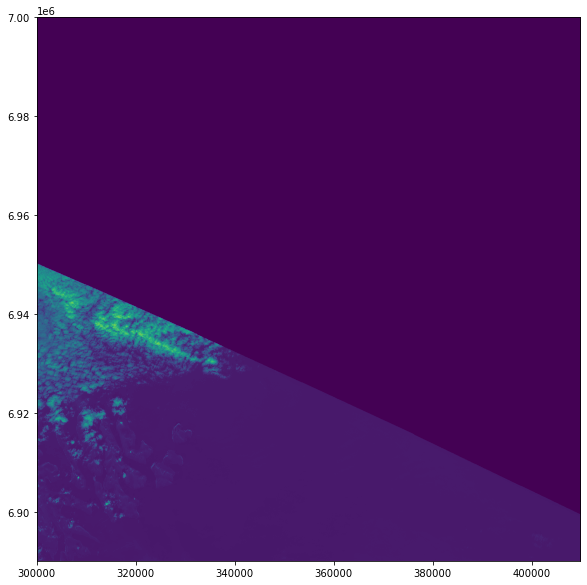

In [14]:
from rasterio.plot import show, show_hist

fig, ax = plt.subplots(figsize=(10, 10))

show(tci_img, transform=tci_metadata['transform'], ax=ax)

Notice in your plot the large portion of the image that is "off the edge of the map" and has a value of 0. This is because the Sentinel 2 metadata doesn't specify a 'nodata value' - note it is 'None' in the output above. We don't want these areas involved in any calculations, therefore we can mask them using the code below.

In [32]:
tci_img = np.ma.masked_array(tci_img, mask=(tci_img==0), fill_value=-999)

tci_metadata['nodata'] = -999

print(tci_img)
print(tci_metadata['nodata'])

[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [255 255 255 ... 10 7 7]
 [255 255 255 ... 7 7 6]
 [255 255 255 ... 6 5 5]]
-999


In [12]:
type(test_img) ## object returned (MaskedArray = Special type of numpy array  => nunpy methods apply easily!)

NameError: name 'test_img' is not defined

(10980, 10980)

(array([1.16056198e+08, 2.08526600e+06, 9.64447000e+05, 7.46442000e+05,
        4.77922000e+05, 1.75473000e+05, 3.89360000e+04, 8.64900000e+03,
        9.06000000e+02, 6.16100000e+03]),
 array([    0. ,  1870.4,  3740.8,  5611.2,  7481.6,  9352. , 11222.4,
        13092.8, 14963.2, 16833.6, 18704. ]),
 <BarContainer object of 10 artists>)

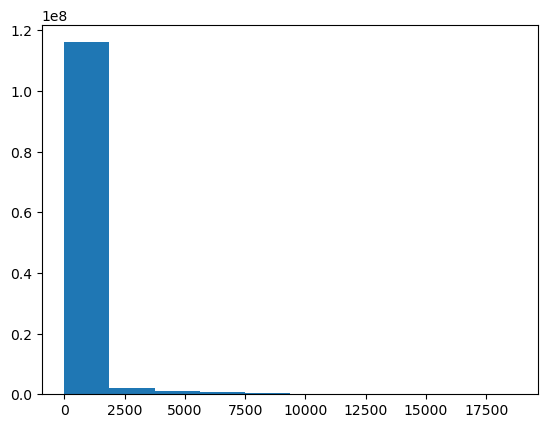

In [46]:
# Understanding distn of pixel values
plt.hist(test_img.flatten())   

**Notice above:** For RGB, integer pixel values take values [0,255], yet above its far higher. Why?

* **Traditional RGB pixels have 8-Bit Depth:** Each channel has 256 shades, so for RGB there are 256x256x256 colours. Often encoded as datatype uint8.
* **Satellites tend to have a larger Bit Depth (12 or 16):** These will be encoded as uint16, and can be seen in the metadata printouts above

**Why do we care?**
It is better to convert ...


In [40]:
## Normalisation & Stretching Example









In [47]:
## See which bands available at which resolution

print('R10m:',img_day_dict['R10m'].keys())
print('R20m:',img_day_dict['R20m'].keys())
print('R60m:',img_day_dict['R60m'].keys())

R10m: dict_keys(['AOT', 'B02', 'B03', 'B04', 'B08', 'TCI', 'WVP'])
R20m: dict_keys(['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B11', 'B12', 'B8A', 'SCL', 'TCI', 'WVP'])
R60m: dict_keys(['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'TCI', 'WVP'])


In [52]:
## Extract individual bands

## 10m picture : B,G,R
# filepaths(fp)
b10_fp = img_day_dict['R10m']['B02']
g10_fp = img_day_dict['R10m']['B03']
r10_fp = img_day_dict['R10m']['B04']

# get imgs
b10 = get_band(b10_fp)
g10 = get_band(g10_fp)
r10 = get_band(r10_fp)


## 60m picture : B
# filepaths (fp)
b60_fp = img_day_dict['R60m']['B02']

# get imgs
b60 = get_band(b60_fp)


Extracting single band from file
Extracting band meta
--> # bands: 1
--> datatype: uint16
--> nodata: None
--> height: 10980
--> width: 10980
--------------------
Extracting single band from file
Extracting band meta
--> # bands: 1
--> datatype: uint16
--> nodata: None
--> height: 10980
--> width: 10980
--------------------
Extracting single band from file
Extracting band meta
--> # bands: 1
--> datatype: uint16
--> nodata: None
--> height: 10980
--> width: 10980
--------------------
Extracting single band from file
Extracting band meta
--> # bands: 1
--> datatype: uint16
--> nodata: None
--> height: 1830
--> width: 1830
--------------------


In [54]:
## Comparing resoltuions & upscaling 

# b60 vs. b10
print('Blue @ 60m res:',b60.shape)
print('Blue @ 10m res:',b10.shape)

# Can see these are covering the same geographic area, but with less granular pixel representation in lower res
# 1 pixel = 60m vs. 1 pixel = 10m

# To create a merged dataset which pulls information from the lower resoltuion bands, they need the same resolution
# (array dimensions/shape)
# TODO: Add link here


Blue @ 60m res: (1830, 1830)
Blue @ 10m res: (10980, 10980)


In [57]:
## Some .jp2 files may contain composite images such as TCI (RGB  - 8bit Depth)

with rio.open(img_day_dict['R10m']['TCI']) as f:

    print('Number of bands in file:',f.profile['count']) 
    multi_band_img = f.read([1,2,3], masked=True) # mark the order you want incoming bands to sit in
    
print(multi_band_img.shape)

Number of bands in file: 3
(3, 10980, 10980)


## Visualisation

In [ ]:
## Creating an 3-band image (here RGB)

rgb10 = np.dstack([r10, g10, b10])

# normalisation?

# something about having to switch the order of array dimensions

plt.imshow(rgb10)

In [58]:
## Masking 